# Example 2 - scalar, Gaussian random walk

Suppose that we have measurements of the scalar $y_k$ from the Gaussian random walk model 
\begin{align}
		x_{k} & =x_{k-1}+ w_{k-1},\quad & w_{k-1}\sim\mathcal{N}(0,Q), \\
		y_{k} & =x_{k}+v_{k},\quad & v_{k}\sim\mathcal{N}(0,R).
\end{align}

This very basic system is found in many applications where $x_k$ represents a slowly varying quantity that we measure directly. The process noise, $w_k,$ takes into account fluctuations in the state $x_k.$ The measurement noise, $v_k,$ accounts for measurement instrument errors. The difference with the previous example, is that here $x$ varies randomly over the time-steps.

We want to estimate the state $x_k$ over time, taking into account the measurements $y_k.$ That is, we would like to compute the filtering density,

$$
   p({x}_{k}\mid{y}_{1:k})=\mathcal{N}\left({x}_{k}\mid{m}_{k},{P}_{k}\right).
$$

We proceed by simply writing down the three stages of the Kalman filter, noting that (as in the previous example) $F_k =1$ and $H_k =1$ for this model. We obtain:

- **Initialization:** Define the prior mean  ${x}_0$ and prior covariance ${P}_0.$
- **Prediction:** 
	\begin{align*}
		{\hat{x}}_{k} & = {x}_{k-1},\\
		\hat{{P}}_{k} & =  {P}_{k-1} + {Q}.
	\end{align*}
 - **Correction:** Define
	\begin{align*}
		{d}_{k} & ={y}_{k}-{\hat{x}}_{k},\quad\textrm{the innovation},\\
		{S}_{k} & =\hat{{P}}_{k}+{R},\quad\textrm{the measurement covariance},\\
		{K}_{k} & =\hat{{P}}_{k}{S}_{k}^{-1},\quad\textrm{the Kalman gain,}
	\end{align*}
	then update,
	\begin{align*}
		{x}_{k} & ={\hat{x}}_{k} + K_k {d}_{k},\\
		P_{k}   & =\hat{P}_{k}-\frac{\hat{P}_{k}^{2}}{S_{k}}.
	\end{align*}

:::{note} 
Note that this formulation is identical with the previous example, except the nature of the measurements, $y_k.$
:::

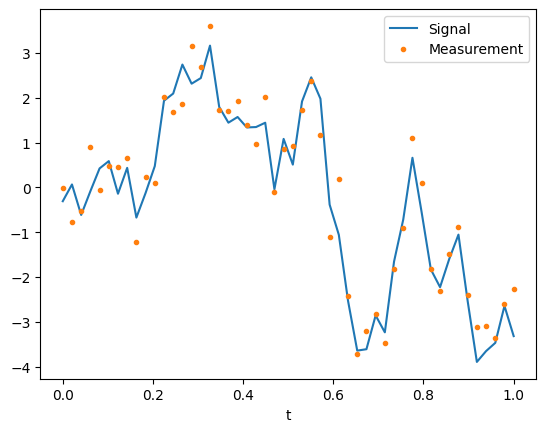

In [1]:
# generate the GRW
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1955)
# time interval and time-step
T = 1
N = 50
dt = T/N
t = np.linspace(0,1,N)
# set parameters
sig_w = 1
sig_v = 0.5
F = 1
Q = sig_w**2
H = 1
R = sig_v**2
# initialize
x0 = 0
P0 = 1
# simulate data
X = np.zeros(N)
Y = np.zeros(N)
x = x0
# loop over time
for j in range(N):
    w = sig_w*np.random.randn()
    x = F*x + w;
    y = H*x + sig_v*np.random.randn()
    X[j] = x
    Y[j] = y
# plot the GRW
plt.plot(t, X, t, Y, '.')
plt.legend(['Signal', 'Measurement'])
plt.xlabel('t')
plt.show()

## Implementation of the KF

Here is a straigthforward, matrix-based implementation of teh KF that follows exactly the thoeretical formulation above.

For more generality, below we will rewrite the Kalman filter as a class.


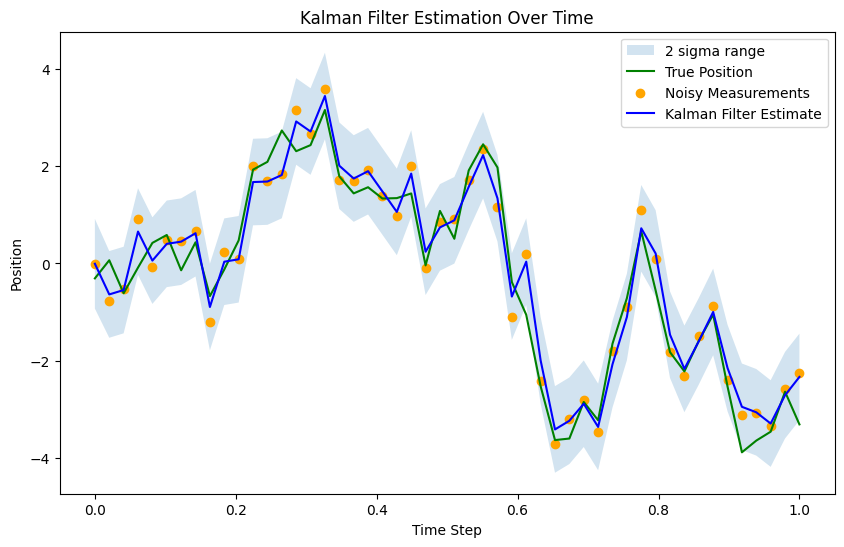

In [2]:
# scalar KF
x = x0
P = P0
# Allocate space for estimated position
estimated_positions  = np.zeros(N)
estimated_covariance = np.zeros(N)
# Kalman Filter Loop
for k in range(N):
    # Predict
    x = F*x
    P = F*P*F + Q    
    # Correct
    d = Y[k] - H*x
    S = H*P*H + R
    K = P*H / S
    x = x + K*d
    P = P - K*S*K
    # Store the filtered position and covariance
    estimated_positions[k]  = x
    estimated_covariance[k] = P
 
# Plot the true positions, noisy measurements, and the Kalman filter estimates
# and the 2 sigma upper and lower analytic population bounds
lower_bound = estimated_positions - 1.96*np.sqrt(estimated_covariance)
upper_bound = estimated_positions + 1.96*np.sqrt(estimated_covariance)

fig, ax = plt.subplots(1, figsize=(10,6))
ax.fill_between(t, lower_bound, upper_bound, facecolor='C0', alpha=0.2,
                label='2 sigma range')
ax.legend(loc='upper left')
ax.plot(t, X, label='True Position', color='green')
ax.scatter(t, Y, label='Noisy Measurements', color='orange', marker='o')
ax.plot(t, estimated_positions, label='Kalman Filter Estimate', color='blue')

plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('Kalman Filter Estimation Over Time')
plt.legend()
plt.show()

## Implementation of KF as a class

For more generality, we rewrite the Kalman filter as a class.


In [3]:
class KalmanFilter:
    """
    An implementation of the classic Kalman Filter for a SCALAR linear dynamic systems.
    The Kalman Filter is an optimal recursive data processing algorithm which
    aims to estimate the state of a system from noisy observations.

    Attributes:
        F (np.ndarray): The state transition matrix.
        B (np.ndarray): The control input marix.
        H (np.ndarray): The observation matrix.
        u (np.ndarray): the control input.
        Q (np.ndarray): The process noise covariance matrix.
        R (np.ndarray): The measurement noise covariance matrix.
        x (np.ndarray): The mean state estimate of the previous step (k-1).
        P (np.ndarray): The state covariance of previous step (k-1).
    """
    def __init__(self, F=None, B=None, H=None, Q=None, R=None, x0=None, P0=None):
        """
        Initializes the Kalman Filter with the necessary matrices and initial state.

        Parameters:
            F (np.ndarray): The state transition matrix.
            B (np.ndarray): The control input marix.
            H (np.ndarray): The observation matrix.
            u (np.ndarray): the control input.
            Q (np.ndarray): The process noise covariance matrix.
            R (np.ndarray): The measurement noise covariance matrix.
            x0 (np.ndarray): The initial state estimate.
            P0 (np.ndarray): The initial state covariance matrix.
        """
        self.F = F  # State transition matrix
        self.B = B  # Control input matrix
        self.u = u  # Control input
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.x = x0  # Initial state estimate
        self.P = P0  # Initial estimate covariance

    def predict(self):
        """
        Predicts the state and the state covariance for the next time step.
        """
        self.x = self.F @ self.x + self.B @ self.u
        self.P = self.F @ self.P @ self.F.T + self.Q
        #return self.x

    def update(self, z):
        """
        Updates the state estimate with the latest measurement.

        Parameters:
            z (np.ndarray): The measurement at the current step.
        """
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y 
        I = np.eye(self.P.shape[0])
        self.P = (I - K @ self.H) @ self.P

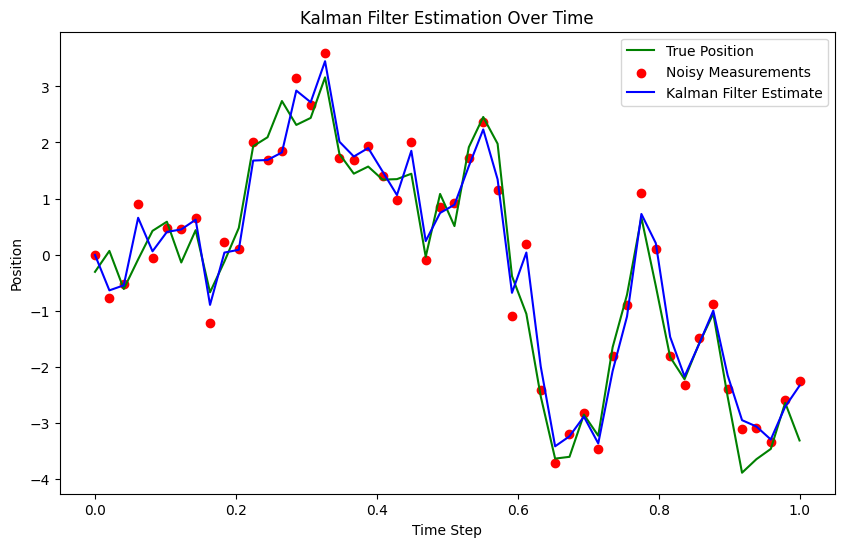

In [4]:
# generate the GRW
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1955)
# time interval and time-step
T = 1
N = 50
dt = T/N
t = np.linspace(0,1,N)
# set parameters
sig_w = 1
sig_v = 0.5
F = 1
Q = sig_w**2
H = 1
R = sig_v**2
# initialize
x0 = 0
P0 = 1
# simulate data
X = np.zeros(N)
Y = np.zeros(N)
x = x0
# loop over time
for j in range(N):
    w = Q*np.random.randn()
    x = F*x + w;
    y = H*x + sig_v*np.random.randn()
    X[j] = x
    Y[j] = y# ready to execute the KF...

# Kalman Filter Initialization
F = np.array([[1]])        # State transition matrix
B = np.array([[0]])        # No control input
u = np.array([[0]])        # No control input
H = np.array([[1]])        # Measurement function
Q = np.array([[sig_w**2]]) # Process noise covariance
R = np.array([[sig_v**2]]) # Measurement noise covariance
x0 = np.array([[0]])       # Initial state estimate
P0 = np.array([[1]])       # Initial estimate covariance

kf = KalmanFilter(F, B, H, Q, R, x0, P0)

# Allocate space for estimated position
estimated_positions = np.zeros(N)

# Kalman Filter Loop
for k in range(N):
    # Predict
    kf.predict()    
    # Correct
    measurement = np.array([[Y[k]]])
    kf.update(measurement)    
    # Store the filtered position 
    estimated_positions[k]  = np.ndarray.item(kf.x[0])

# Plot the true positions, noisy measurements, and the Kalman filter estimates
plt.figure(figsize=(10, 6))
plt.plot(t, X, label='True Position', color='green')
plt.scatter(t, Y, label='Noisy Measurements', color='red', marker='o')
plt.plot(t, estimated_positions, label='Kalman Filter Estimate', color='blue')

plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('Kalman Filter Estimation Over Time')
plt.legend()
plt.show()